In [4]:
from typing import Annotated, Sequence, TypedDict, List, cast
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
import pandas as pd
import json
from pydantic import BaseModel
import random

In [5]:
load_dotenv()

True

In [15]:
class AgentState(TypedDict):
    topic_history: List[str]
    topic: str
    tone: str
    outline: str
    draft: str

In [7]:
class TopicResponse(BaseModel):
    topic: str
    tone: str

In [8]:
def random_filter(lst: list[str], p: float) -> list[str]:
    """
    p = probabilidade de REMOVER (0.0 a 1.0)
    """
    return [x for x in lst if random.random() > p]

In [ ]:
MIN_WORDS_DRAFT = 1000
MAX_WORDS_DRAFT = 1500
TARGET_MINUTES_DRAFT = 10

FINE_TUNES_OUTLINE = ["Inclua um elemento cotidiano banal que se torne perturbador"
                  ,"Mantenha dúvida se os eventos são psicológicos ou reais"
                  ,"Evite clichês óbvios de terror"
                  ,"Deixe ao menos uma interpretação racional possível"
                  ,"O narrador demonstra dúvida sobre a própria memória"
                  ,"Alguns detalhes parecem contraditórios, mas nunca são explicados"
                  ,"Não esclareça se outras pessoas perceberam os eventos"
                  ,"Intercale trechos mais calmos com eventos breves e perturbadores"
                  ,"Transforme um objeto comum em algo inquietante"
                  ,"Use um som cotidiano que passa a causar desconforto"
                  ,"Inclua uma rotina simples que se torna estranha"
                  ,"Algo banal se repete de forma errada"
                  ,"Um detalhe pequeno se torna impossível de ignorar"
                  ,"O local é familiar, mas silencioso demais"
                  ,"A ambientação é descrita mais por sensações do que por detalhes visuais"
                  ,"O espaço parece maior ou menor do que deveria"
                  ,"O ambiente muda sutilmente ao longo da história"
                  ,"O narrador perde a noção do tempo em certos momentos"
                  ,"Eventos parecem acontecer fora de ordem"
                  ,"Alguns lapsos de memória são mencionados"
                  ,"O narrador não sabe quanto tempo se passou"
                  ,"Datas e horários são imprecisos"
                  ,"Outras pessoas aparecem pouco e de forma indireta"
                  ,"Personagens secundários não percebem nada estranho"
                  ,"A reação dos outros é desconfortavelmente neutra"
                  ,"Alguém reage de forma errada à situação"
                  ,"Um personagem evita falar sobre o ocorrido"]

FINE_TUNES_DRAFT = ["O narrador soa cansado e hesitante."
                    ,"O narrador tenta minimizar o que aconteceu, mas falha."
                    ,"O narrador evita usar palavras diretamente assustadoras"
                    ,"O narrador se corrige em alguns momentos"
                    ,"O narrador parece relutante em contar a história"
                    ,"Use frases muito curtas em momentos de tensão"
                    ,"Evite descrições longas no clímax"
                    ,"Faça o clímax acontecer rapidamente, sem preparação explícita"
                    ,"Inclua pausas naturais após eventos estranhos"
                    ,"Evite descrever o espaço de forma completa"
                    ,"Outras pessoas aparecem pouco e de forma indireta"
                    ,"Evite qualquer explicação final"
                    ,"O final deve levantar mais perguntas do que respostas"
                    ,"O narrador encerra a história abruptamente"
                    ,"O último evento não é o mais assustador"
                    ,"O encerramento acontece após uma ação aparentemente trivial"
                    ,"Evite linguagem excessivamente descritiva"
                    ,"Prefira verbos simples"
                    ,"Não use metáforas elaboradas"
                    ,"Repita palavras ocasionalmente"
                    ,"Use construções ligeiramente imperfeitas"]



In [10]:
tools = []

In [11]:
model = ChatOpenAI(model="gpt-4o-mini")

In [12]:
topic_model = model.with_structured_output(TopicResponse)

In [ ]:
def get_topic_history(state: AgentState) -> AgentState:
    """Function to get the subject history"""
    
    try:
        df = pd.read_parquet("data/topic_history.parquet")
        topic_history = df['topic_history'].tolist()
    except:
        topic_history = []
    
    return {**state, "topic_history":topic_history}

def get_topic(state: AgentState) -> AgentState:
    """Calls an LLM and ask's for a topic for an horror story"""
    system_prompt = SystemMessage(content=f"""Você é uma assistente focada em sugerir tópicos para histórias de suspense e terror com finais ambíguos e vagos.
                                Responda **exclusivamente** em JSON válido no formato:
                                {{
                                "topic": "...",
                                "tone": "..."
                                }}
                                Onde
                                "topic" (que deve ter como valor o tópico sugerido), ex: "Relato de vigia noturno em estrada rural"
                                "tone" (que deve ter como valor o tom da história), ex: "realista, cansado"
                                É importante que você não repita tópicos já utilizados anteriormente. A seguir esta uma lista de tópicos já utilizados: {state['topic_history']}
                                """)
    
    human_prompt = HumanMessage(content="""Me sugira um tópico para uma história de terror e suspense""")
    
    response = cast(TopicResponse, topic_model.invoke([system_prompt, human_prompt]))

    
    return {**state, "topic":response.topic, "tone":response.tone}

def get_outline(state: AgentState) -> AgentState:
    """Calls an LLM and ask's for an outline for an horror story"""
    
    mods = random.sample(FINE_TUNES_OUTLINE, k=random.randint(1, 3))

    system_prompt = SystemMessage(content=f"""Você é um roteirista de histórias de terror em primeira pessoa.

                                    Crie APENAS um outline estruturado (não escreva a história),
                                    para um vídeo de terror narrado com duração aproximada de 8 a 10 minutos.

                                    Requisitos:
                                    - Narrativa em primeira pessoa
                                    - Tom sombrio, inquietante e ambíguo
                                    - Escalada lenta de tensão
                                    - Clímax próximo ao final (entre 65% e 80% da história)
                                    - Final aberto, sem explicações claras

                                    Requisitos Adicionais: {",".join(mods)}

                                    Estrutura obrigatória:
                                    1. Hook (20–30 segundos)
                                    2. Ato 1 – Contexto inicial
                                    3. Ato 2 – Escalada dos acontecimentos
                                    4. Clímax
                                    5. Encerramento ambíguo

                                    Formato de saída:
                                    - Use tópicos curtos (1–2 frases por seção)
                                    - Não escreva diálogos longos
                                    - Não escreva descrições detalhadas
                                    - Não finalize a história

                                    Retorne SOMENTE o outline estruturado.
                                    """)
    
    human_prompt = HumanMessage(content=f"""Tema da História: {state['topic']}
                               Tom da História: {state['tone']}""")
    
    response = model.invoke([system_prompt,human_prompt])

    return {**state, "outline":str(response.content)}

def get_draft(state: AgentState) -> AgentState:
    """Calls an LLM, provides an outline, and ask's for a story draft"""

    mods = random.sample(FINE_TUNES_DRAFT, k=random.randint(1, 3))
    
    system_prompt = SystemMessage(content=f"""
                    Você é um escritor de histórias de terror em primeira pessoa.

                Escreva a HISTÓRIA COMPLETA com base no outline fornecido.

                Requisitos obrigatórios:
                - Narrativa em primeira pessoa (“eu”)
                - Tom sombrio, inquietante e contido
                - Ritmo lento, com escalada gradual de tensão
                - Linguagem simples e direta
                - Sem explicações claras ou conclusões definitivas
                - Evite clichês óbvios de terror

                Duração:
                - A história deve ter entre {MIN_WORDS_DRAFT} e {MAX_WORDS_DRAFT} palavras
                - Ritmo adequado para narração em vídeo de aproximadamente {TARGET_MINUTES_DRAFT} minutos

                Estrutura:
                - Siga fielmente o outline fornecido
                - O clímax deve ocorrer apenas próximo ao final
                - O encerramento deve ser ambíguo e desconfortável

                Restrições importantes:
                - NÃO escreva título
                - NÃO use listas
                - NÃO faça comentários sobre a história
                - NÃO explique o significado dos eventos
                - NÃO finalize com lições, revelações ou moral

                Ajustes adicionais de estilo (aplique apenas se fizer sentido):
                {FINE_TUNES_DRAFT}

                Retorne APENAS o texto da história.
                """)
    
    human_prompt = HumanMessage(content=f"Outline: {state['outline']}")
    response = model.invoke([system_prompt,human_prompt])

    return {**state , "draft":str(response.content)}

In [14]:
graph = StateGraph(AgentState)

graph.add_node("topic_history_node", get_topic_history)
graph.add_node("topic_node", get_topic)

graph.set_entry_point("topic_history_node")
graph.add_edge("topic_history_node", "topic_node")
graph.add_edge("topic_node", END)

agent = graph.compile()

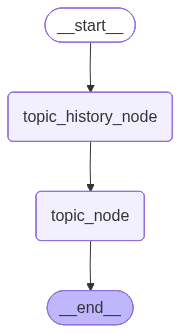

In [27]:
agent

In [28]:
agent.invoke({})

{'topic_history': [],
 'topic': 'Uma coleção de cartas antigas que revelam segredos obscuros de um vilarejo',
 'tone': 'misterioso, inquietante'}